# 04 - Model Building
In this notebook we are going to build and train a classification model to predict if a flight price will drop in the future or not.

Steps:
1. Load data
2. Select and preprocessing features
3. Train model
4. Evaluation on validation
5. Best model evaluation on test
4. Store model for front-end

### Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, auc, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [35]:
# Import PriceEstimatorTrainer from src folder
import os, sys
from pathlib import Path

cwd = os.getcwd()
path = Path(cwd)
parent = str(path.parent.absolute())

if parent + '/src/' not in sys.path:
    sys.path.append(parent + '/src/')
    
import config as cfg
from PriceEstimatorTrainer import PriceEstimatorTrainer

### Functions

In [36]:
def create_pipeline(model, scaler=StandardScaler(), encoder=OneHotEncoder(handle_unknown='ignore')):
    """ Return a preprocessing pipeline that scale numerical variables
        and encode categorical ones """
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', scaler),     
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', encoder),
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num),
        ('cat', cat_pipeline, cat),
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model),
    ])

    return pipeline

In [37]:
def plot_feature_importances(model, X, y):
    """  Plot feature importances using a random forest classifier """
    X = X.copy()
    y = y[:]
    scaler = StandardScaler()
    encoder = LabelEncoder()
    X[num] = scaler.fit_transform(X[num])
    for col in cat:
        X[col] = encoder.fit_transform(X[col])
    model.fit(X, y)
    importances = model.feature_importances_
    features = list(X.columns)
    
    df = pd.DataFrame(importances, index=features, columns=['importance']).sort_values(ascending=False, by='importance')
    plt.figure(figsize=(5, 3))
    plt.title("Feature Importances", fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("")
    sns.barplot(y=df.index, x=df['importance'], palette='Blues_r')
    sns.despine(offset=10)

In [38]:
def get_metrics(estimator, X, y_true):
    """ Return some classification metrics """
    y_pred = estimator.predict(X)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f'Accuracy: {acc:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')
    
    plot_confusion_matrix(estimator, X, y_true, cmap='Blues')

In [39]:
def get_actual_labels(row):
    """ Assign wait or buy label using actual data """
    current_d = row['days_until_dep']
    current_price = row['price']
    list_prices = np.array(row['list_prices'])
    next_days = list_prices[:current_d-1]
    if len(next_days) == 0:
        return 0
    else:
        min_price = np.min(next_days)

        if min_price < current_price and 1-(min_price/current_price) > min_drop_per:
            return 1
        else:
            return 0

In [40]:
def get_estimated_price(row):
    list_prices = row['list_price_est']
    current_bin = row['days_bins']
    current_price = list_prices[current_bin]
    next_prices = list_prices[:current_bin]
    if next_prices == []:
        print(row['id'])
    min_bin = np.argmin(next_prices)
    min_price = next_prices[min_bin]
    return min_price, min_bin, current_price

In [41]:
def get_wait_prices(row):
    list_prices = row['list_prices']
    current_day = row['days_until_dep']
    min_wait = row['min_wait']
    max_wait = row['max_wait']
    i = current_day-max_wait
    j = current_day-min_wait
    wait_prices = list_prices[i:j]
    if wait_prices == []:
        return np.nan
    return np.min(wait_prices)

In [42]:
# Config. variables
agg_cols = ['orig-dest', 'airline', 'session', 'days_until_dep']
min_drop_per = 0.05

## 1. Load data

In [43]:
train = pd.read_csv('../data/processed/train.csv')
train.shape

(36975, 12)

In [44]:
valid = pd.read_csv('../data/processed/valid.csv')
valid.shape

(73104, 17)

In [45]:
test = pd.read_csv('../data/processed/test.csv')
test.shape

(73105, 17)

In [46]:
price_bins = pd.read_csv('../data/processed/price_bins.csv')
bins_days = pd.read_csv('../data/processed/bins_days.csv')

## 2. Select and preprocessing features

In [47]:
# categorical
cat = ['orig-dest', 'airline', 'session']

# numerical
num = ['days_until_dep', 'competition', 'prob', 'fly_duration']

# target
target = 'wait'

In [48]:
# select features and split target
X = train[cat+num].copy()
y = train[target].values

## 3. Training model

In [49]:
# models
rf = RandomForestClassifier(max_depth=6, random_state=42)

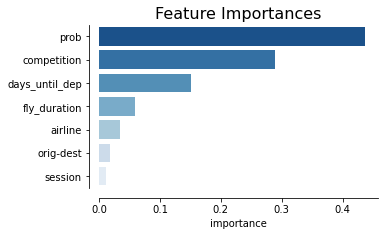

In [50]:
plot_feature_importances(rf, X, y)

In [51]:
model = create_pipeline(rf)

In [52]:
# training 
model.fit(X, y);

Accuracy: 0.76
F1-Score: 0.82
ROC AUC: 0.74


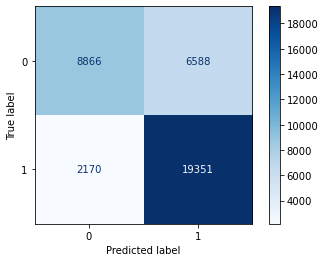

In [53]:
# eval on training
get_metrics(model, X, y)

## 4. Evaluation on validation

In order to evaluate the model we have to simulate a number of passengers wishing to buy airline tickets on certain days, apply the model predictions and check how much money they have saved if the model predicted they had to wait.
\
I am going to use my custom class PriceEstimatorTrainer for building the model. Source code is in src folder. All the training process and hypertuning has been made with the python scripts in src folder. In this notebook I will show the final results and save the model for the front-end

In [54]:
# training with price estimator
m = RandomForestClassifier(max_depth=6, random_state=cfg.RANDOM_STATE)
trainer = PriceEstimatorTrainer(model=m, pred_threshold=.5, n=10000)
trainer.fit()

                 Model  Savings (k€)  Losses (k€)  Mean (%) Accuracy f1-score Precision Recall
RandomForestClassifier          23.3         -4.9      11.0   41.28%   30.19%    77.53% 18.75%


           Savings (k€)  Losses (k€)  Mean Savings (€) Savings Percentage Wait predicted Wait correctly predicted
orig-dest                                                                                                        
BCN-AMS             4.0         -1.4              7.96              6.92%          22.5%                   17.02%
BCN-FCO             2.1         -0.2             12.46              13.9%         11.86%                    9.28%
BCN-LGW             1.8         -0.3             12.00             12.35%         28.34%                   22.45%
BCN-PMI             1.4         -0.0              7.17             29.29%         28.02%                   21.05%
MAD-BCN             0.3         -0.1              4.62              2.06%          4.27%                    3.17%
MAD-EZE   

(77.53357753357754, 11.0)

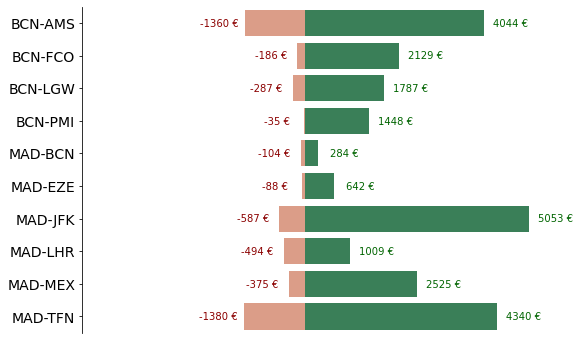

In [55]:
trainer.evaluate(on='valid', plot=True)

## 5. Best model evaluation on test

                 Model  Savings (k€)  Losses (k€)  Mean (%) Accuracy f1-score Precision Recall
RandomForestClassifier          22.3         -6.0      10.0    43.1%   30.76%    74.57% 19.38%


           Savings (k€)  Losses (k€)  Mean Savings (€) Savings Percentage Wait predicted Wait correctly predicted
orig-dest                                                                                                        
BCN-AMS             3.4         -0.9              8.89              8.42%         18.17%                    15.9%
BCN-FCO             1.3         -0.2              7.52             11.44%         11.18%                    9.25%
BCN-LGW             1.3         -0.2             12.51             13.72%         21.65%                   14.59%
BCN-PMI             1.4         -0.1              5.71             23.82%         33.78%                   21.73%
MAD-BCN             0.2         -0.1              2.27              2.44%          4.84%                    3.85%
MAD-EZE   

(74.57227138643067, 10.0)

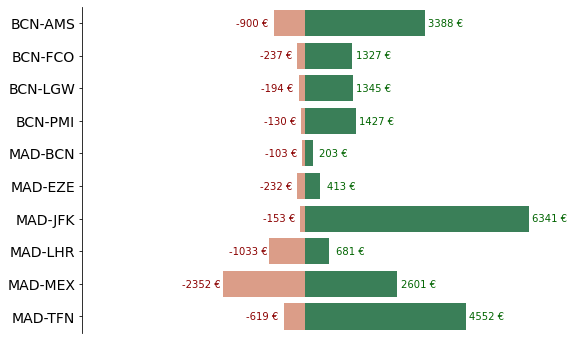

In [56]:
trainer.evaluate(on='test', plot=True)

## 6. Store model for front-end

In [57]:
model = trainer.model
pickle.dump(model, open('../models/rf.pkl', 'wb'))